In [1]:
from utils import plot_history, plot_result, calc_mean_image_metrics, predict_all
from losses import ssim_l2

In [2]:
import numpy as np

import os

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Add, Subtract, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, PReLU
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import callbacks
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
images_clear_tt = np.load('images_clear_tt.npy')
images_noised_tt = np.load('images_noised_tt.npy')
images_clear_tt = images_clear_tt[:2000]
images_noised_tt = images_noised_tt[:2000]

In [4]:
#images_noised_train, images_noised_test, images_clear_train, images_clear_test = train_test_split(images_noised_tt,
#                                                                                                 images_clear_tt,
#                                                                                                 test_size=0.2,
#                                                                                                 random_state=42)

In [5]:
def model_unet(img_shape):
    
    input = Input(img_shape)

    conv1_1 = Conv2D(64, kernel_size=(2,2), activation='relu', padding='same')(input)
    conv1_2 = Conv2D(64, kernel_size=(2,2), activation='relu', padding='same')(conv1_1)
    conv1_p = MaxPooling2D(2,2)(conv1_2)
    conv1_bn = BatchNormalization()(conv1_p)

    conv2_1 = Conv2D(128, kernel_size=(2,2), activation='relu', padding='same')(conv1_bn)
    conv2_2 = Conv2D(128, kernel_size=(2,2), activation='relu', padding='same')(conv2_1)
    conv2_p = MaxPooling2D(2,2)(conv2_2)
    conv2_bn = BatchNormalization()(conv2_p)

    conv3_1 = Conv2D(256, kernel_size=(2,2), activation='relu', padding='same')(conv2_bn)
    conv3_2 = Conv2D(256, kernel_size=(2,2), activation='relu', padding='same')(conv3_1)
    conv3_p = MaxPooling2D(2,2)(conv3_2)
    conv3_bn = BatchNormalization()(conv3_p)

    conv4_1 = Conv2D(512, kernel_size=(2,2), activation='relu', padding='same')(conv3_bn)
    conv4_2 = Conv2D(512, kernel_size=(2,2), activation='relu', padding='same')(conv4_1)
    conv4_p = MaxPooling2D(2,2)(conv4_2)
    conv4_bn = BatchNormalization()(conv4_p)

    conv_btnk = Conv2D(1024, kernel_size=(2,2), activation='relu', padding='same')(conv4_bn)
    conv_btnk = Conv2D(1024, kernel_size=(2,2), activation='relu', padding='same')(conv_btnk)

    upconv4_1 = Conv2DTranspose(512, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(conv_btnk)
    upconv4_sum = Concatenate()([upconv4_1, conv4_2])
    upconv4_bn = BatchNormalization()(upconv4_sum)
    upconv4_2 = Conv2D(512, kernel_size=(2,2), activation='relu', padding='same')(upconv4_bn)
    upconv4_3 = Conv2D(512, kernel_size=(2,2), activation='relu', padding='same')(upconv4_2)

    upconv3_1 = Conv2DTranspose(256, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(upconv4_3)
    upconv3_sum = Concatenate()([upconv3_1, conv3_2])
    upconv3_bn = BatchNormalization()(upconv3_sum)
    upconv3_2 = Conv2D(256, kernel_size=(2,2), activation='relu', padding='same')(upconv3_bn)
    upconv3_3 = Conv2D(256, kernel_size=(2,2), activation='relu', padding='same')(upconv3_2)

    upconv2_1 = Conv2DTranspose(128, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(upconv3_3)
    upconv2_sum = Concatenate()([upconv2_1, conv2_2])
    upconv2_bn = BatchNormalization()(upconv2_sum)
    upconv2_2 = Conv2D(128, kernel_size=(2,2), activation='relu', padding='same')(upconv2_bn)
    upconv2_3 = Conv2D(128, kernel_size=(2,2), activation='relu', padding='same')(upconv2_2)

    upconv1_1 = Conv2DTranspose(64, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(upconv2_3)
    upconv1_sum = Concatenate()([upconv1_1, conv1_2])
    upconv1_bn = BatchNormalization()(upconv1_sum)
    upconv1_2 = Conv2D(64, kernel_size=(2,2), activation='relu', padding='same')(upconv1_bn)
    upconv1_3 = Conv2D(64, kernel_size=(2,2), activation='relu', padding='same')(upconv1_2)

    conv_out = Conv2D(3, kernel_size=(1,1), activation='relu', padding='same')(upconv1_3)
    out_s = Subtract()([input, conv_out])
    out = out_s

    model = Model(input, out)
    model.summary()
    
    return model

In [6]:
model = model_unet((256,256,3))
reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss',
                                        factor=0.1,
                                        patience=5)

model.compile(optimizer=Adamax(learning_rate=1e-3), loss=ssim_l2)

history = model.fit(images_noised_tt, images_clear_tt,
                    epochs=45,
                    callbacks=[reduce_lr],
                    validation_split=0.2,
                    #validation_data=(images_noised_test, images_clear_test),
                    batch_size=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  832         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  16448       ['conv2d[0][0]']                 
                                )                                                             

                                6)                                'conv2d_3[0][0]']               
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 128, 128, 25  1024       ['concatenate_2[0][0]']          
 rmalization)                   6)                                                                
                                                                                                  
 conv2d_14 (Conv2D)             (None, 128, 128, 12  131200      ['batch_normalization_6[0][0]']  
                                8)                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 12  65664       ['conv2d_14[0][0]']              
                                8)                                                                
          

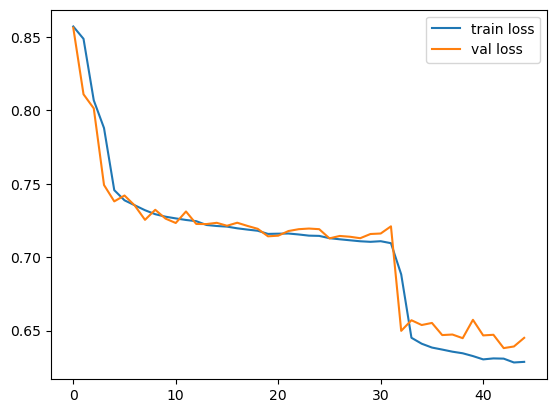

In [7]:
plot_history(history)

In [10]:
y_tt = predict_all(model, images_noised_tt)

1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 54ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mean PSNR=13.052375793457031
mean SSIM=0.40993720293045044


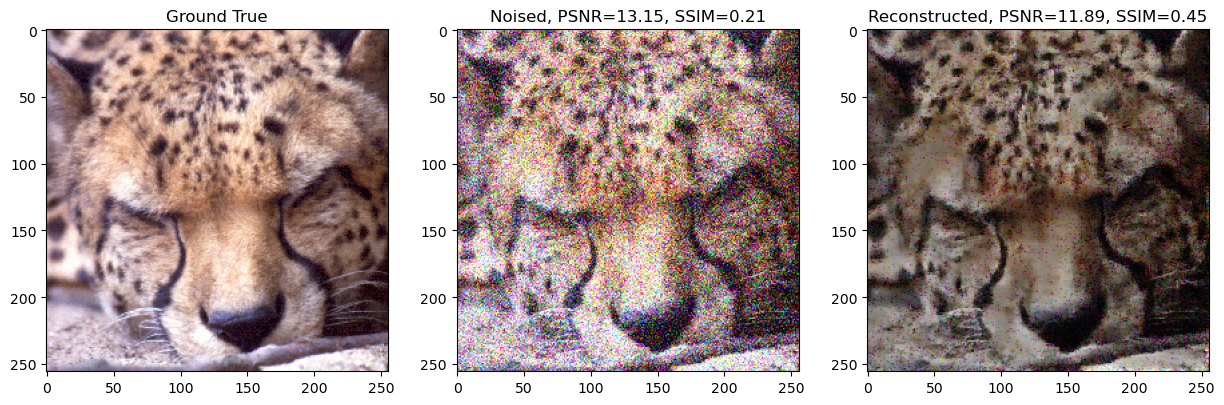

In [11]:
n=5
max_value=1
psnr, ssim = calc_mean_image_metrics(images_clear_tt, y_tt, max_value=max_value)
print (f'mean PSNR={psnr}')
print (f'mean SSIM={ssim}')
plot_result(images_clear_tt[n],
            images_noised_tt[n],
            y_tt[n],
            max_value=max_value
           )

In [12]:
#model = model_unet((256,256,3))
#model.save('saved/unet/unet.h5', save_format='h5')